# CLAP Few Shot learning using Contrastive Losses


This notebook implements a **few-shot audio classification system** for distinguishing between cat and dog sounds using contrastive learning techniques. The system leverages a pre-trained CLAP (Contrastive Language-Audio Pre-training) model as a frozen feature extractor and trains only a small projection head using limited labeled data (5 samples per class by default).



### 1. **Contrastive Learning Approaches**

The notebook implements two distinct contrastive learning strategies:

#### **Triplet-Based Contrastive Loss**
- Uses **anchor-positive-negative triplets** where:
 - Anchor: reference audio sample
 - Positive: different sample from same class (cat/dog)
 - Negative: sample from different class
- **Margin Ranking Loss**: Encourages `similarity(anchor, positive) > similarity(anchor, negative) + margin`
- Good for learning discriminative features when you have clear positive/negative pairs

#### **Supervised Contrastive Loss (InfoNCE-style)**
- Treats all samples from the same class as positives
- Uses **temperature-scaled cosine similarities** to create probability distributions. This controls softmax sharpness in supervised contrastive loss
- More robust to batch composition and can leverage multiple positives simultaneously
- Formula: `-log(sum(exp(sim_positive/τ)) / sum(exp(sim_all/τ)))`

### 2. **Few-Shot Learning Strategy**

- Only 5 samples per class for training
- CLAP model parameters are frozen to prevent overfitting
- Only a small linear layer (512→128 dimensions) is trained
- Leverages CLAP's pre-trained audio-text representations


### 3. **Class Imbalance Handling by Oversampling Strategy**
- Replicates minority class samples up to 3x 
- Maintains class balance without losing data from majority class


### 4. **Evaluation Strategy**

#### **Centroid-Based Classification**
- Computes class centroids from training embeddings
- Classifies test samples by nearest centroid (cosine similarity)
- Robust evaluation method for few-shot scenarios
- No additional classifier training required

### 5. **Embedding Visualization**

- Visualizes learned embeddings in 2D space
- Dynamically adjusts perplexity based on sample count
- Monitors clustering quality across training epochs
- Helps diagnose if contrastive learning is creating meaningful separations

### 7. **Technical Implementation Details**
- **Gradient Clipping**: Prevents exploding gradients (max_norm=1.0)
- **Similarity Clamping**: Bounds cosine similarities to [-1, 1]
- **Temperature Scaling**: Controls softmax sharpness in supervised contrastive loss
- **NaN/Inf Handling**: Robust error checking and fallback mechanisms
- **Stratified Splitting**: Maintains class proportions across train/val/test
- **Batch Validation**: Ensures batches contain multiple classes for supervised contrastive loss


In [1]:
import os
import random
import numpy as np
import torch
import torchaudio
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import ClapProcessor, ClapModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pathlib import Path
import pytorch_lightning as pl

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def set_all_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    pl.seed_everything(seed, workers=True)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_all_seeds(42)

# Configuration
CONFIG = {
    "data_dir": "data/cat_dog_audio",
    "balance_method": "oversample",
    "oversample_multiplier": 3,
    "few_shot_per_class": 5,
    "batch_size": 8,
    "epochs": 5,
    "lr": 1e-6,
}


Seed set to 42


In [2]:
from src.plots import audio_eda, plot_sample_waveforms
from src.audio import normalize_audio, standardize_duration, augment_audio, preprocess_audio_file
from src.dataset import balance_dataset_explicit
from src.plots import audio_eda, plot_sample_waveforms
from src.training import train_contrastive_model, train_supervised_contrastive_model


In [3]:
def download_kaggle(dest):
    if dest.exists() and list(dest.rglob("*.wav")):
        return
    dest.mkdir(parents=True, exist_ok=True)
    os.system(f"kaggle datasets download -d mmoreaux/audio-cats-and-dogs -p {dest} --unzip")
download_kaggle(Path(CONFIG["data_dir"]))

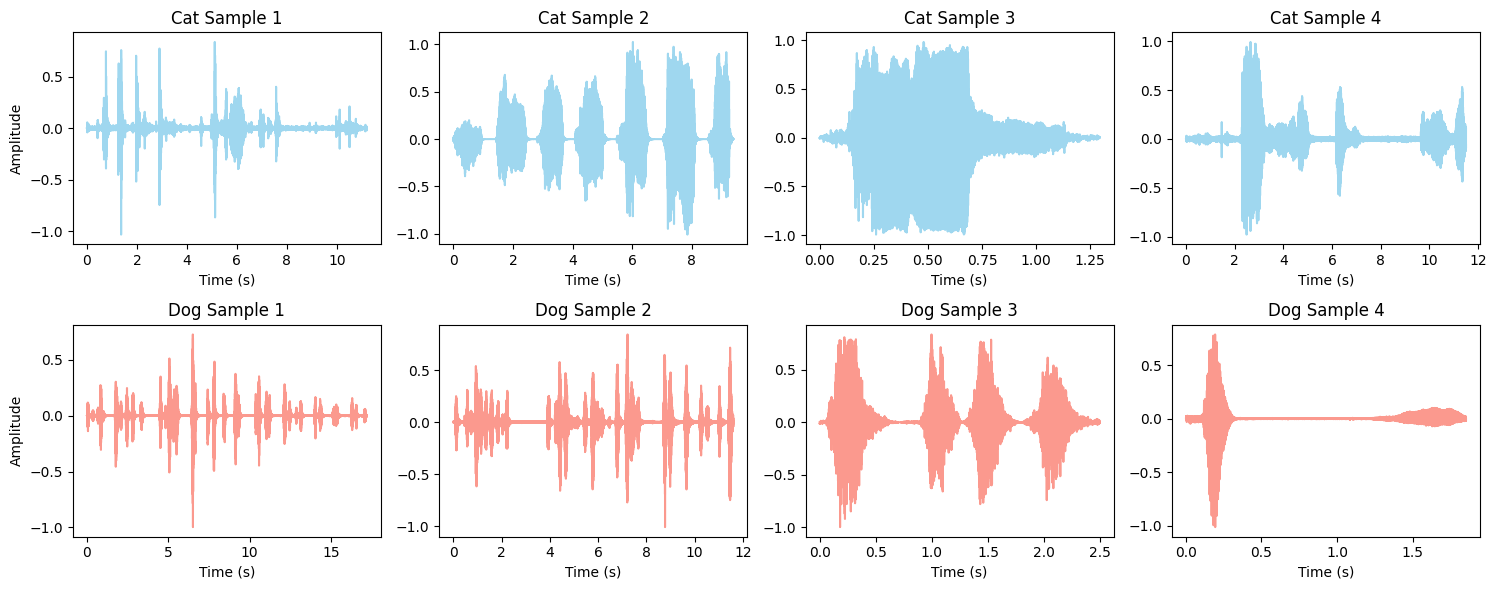

In [4]:
plot_sample_waveforms("data/cat_dog_audio")

e:\Studies\vopemed\src\plots.py:37: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=str(wav_path))


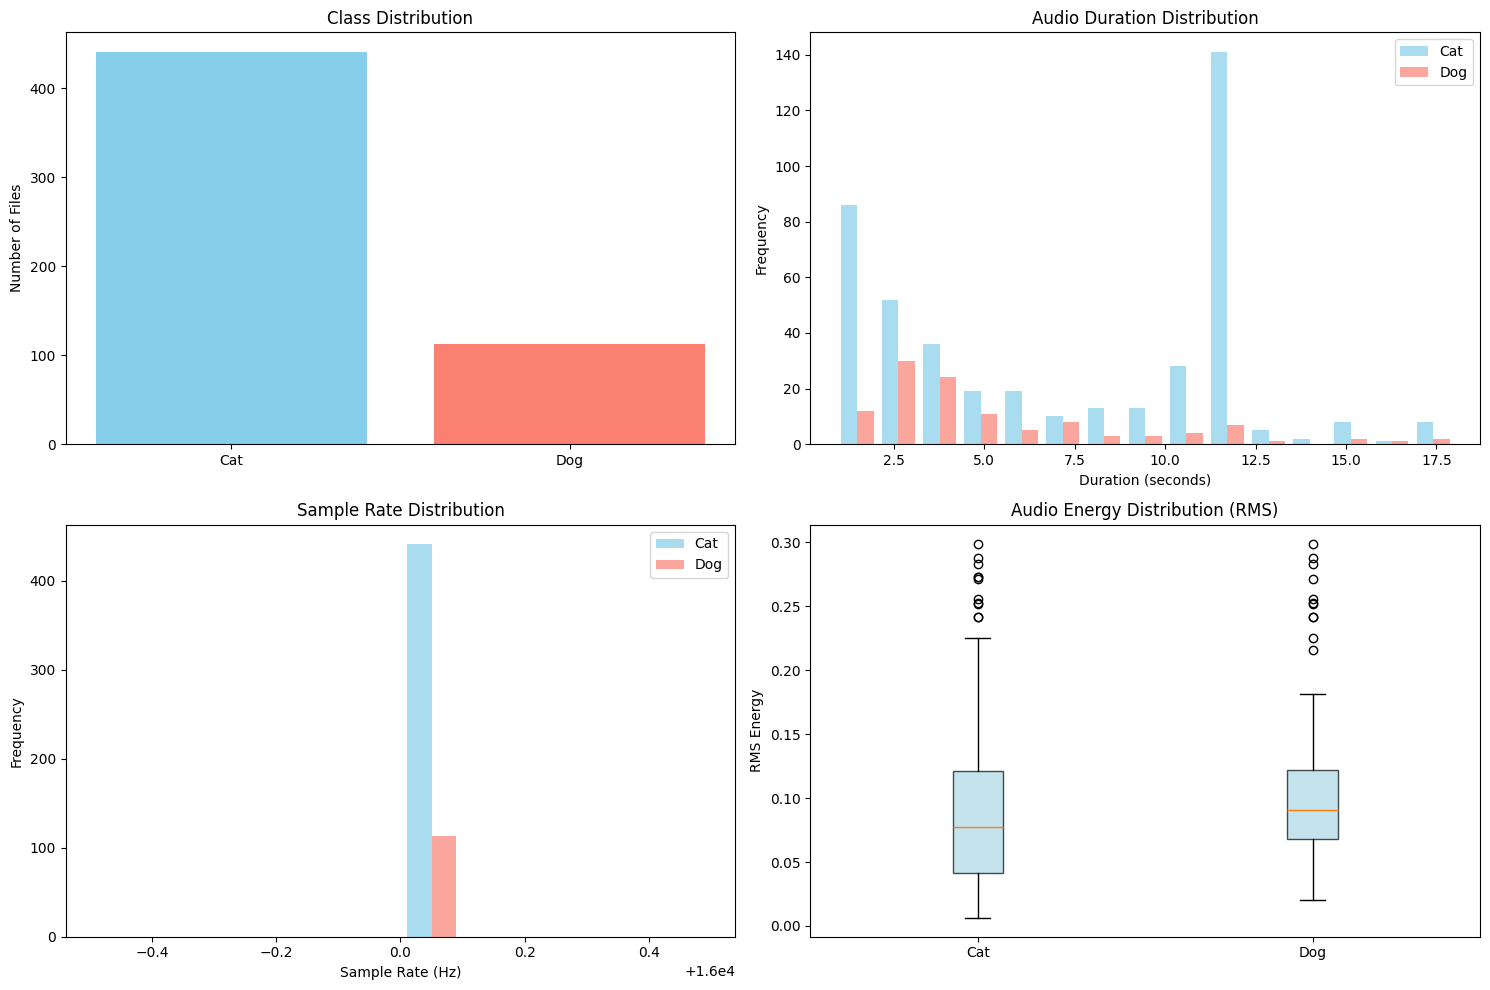

=== Dataset Summary ===
Total files: 554
Cat files: 441 (79.6%)
Dog files: 113 (20.4%)

Duration stats (seconds):
  Mean: 6.94
  Std: 4.58
  Min: 0.92
  Max: 17.98

Sample rates found: {16000}


In [5]:
audio_eda("data/cat_dog_audio")  

#### Analysis:

- Audio durations show two peaks : brief clips (~1–2 s) and longer calls (~12 s). Cats are more variable and dogs mostly short.

- Sample rates mix 16 kHz and 44 kHz -> resampling everything to 16 kHz. 

- Energy levels are similar across classes but with extreme outliers -> normalizing energy and removing noisy recordings.


#### **Standardization Techniques**
- **Duration Normalization**: Pads short clips to 3 seconds, segments long clips with 50% overlap
- **Energy Normalization**: RMS normalization with peak limiting backup
- **Sample Rate Consistency**: Resamples all audio to 48kHz for CLAP compatibility
- **Silence Trimming**: Removes quiet sections using librosa's trim function



 ****************************** supervised contrastive with over sampling Dog ****************************** 

Using device: cuda


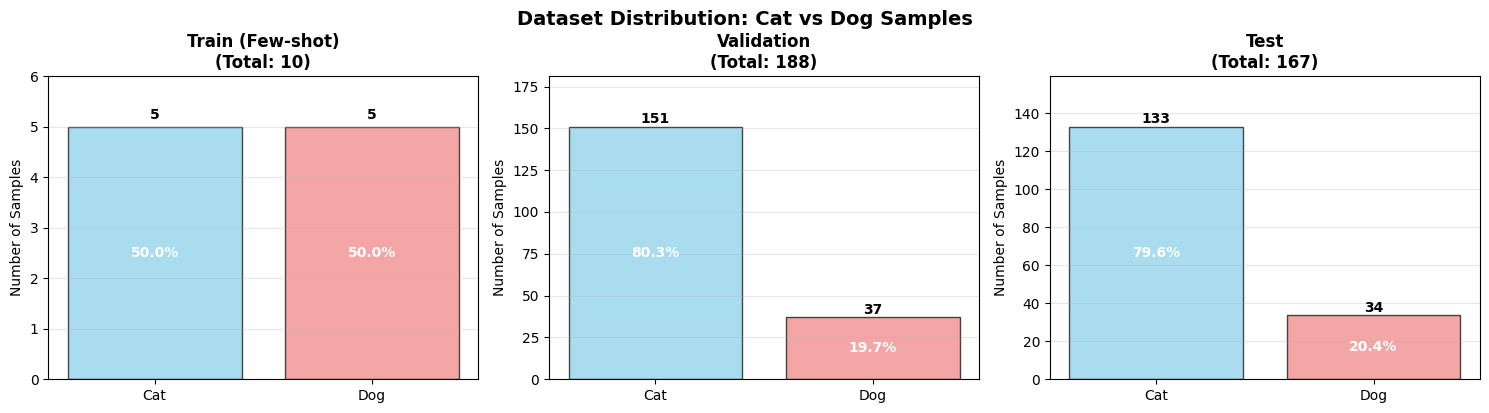


Dataset Distribution Summary:
----------------------------------------
Train (Few-shot): Cat= 5, Dog= 5, Total=10
Validation     : Cat=151, Dog=37, Total=188
Test           : Cat=133, Dog=34, Total=167
Dataset sizes: {'train': 10, 'val': 188, 'test': 167}
Training supervised contrastive model for 5 epochs...
  Batch 0: size=8, labels=[0, 0, 0, 1, 1, 0, 1, 0]
  Batch 1: size=2, labels=[1, 1]
  Skipping batch 1: size=2, unique_labels=1
  Processed 1/1 batches successfully


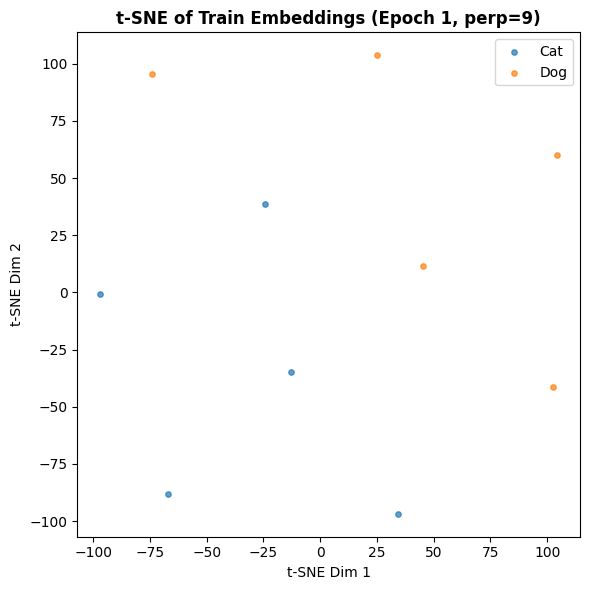

Epoch  1/5 | Train SupCon Loss=0.381 | Val Centroid Acc=0.745
  Batch 0: size=8, labels=[0, 1, 1, 0, 1, 1, 0, 0]
  Batch 1: size=2, labels=[0, 1]
  Processed 2/2 batches successfully


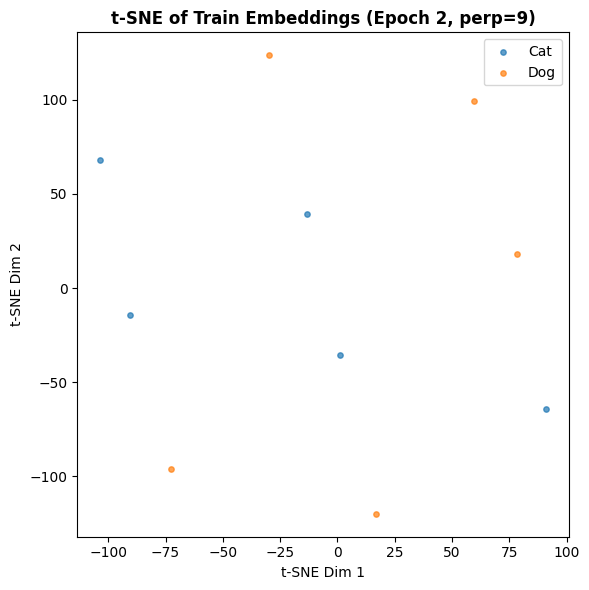

Epoch  2/5 | Train SupCon Loss=0.131 | Val Centroid Acc=0.750
  Batch 0: size=8, labels=[1, 0, 1, 1, 0, 0, 0, 1]
  Batch 1: size=2, labels=[1, 0]
  Processed 2/2 batches successfully


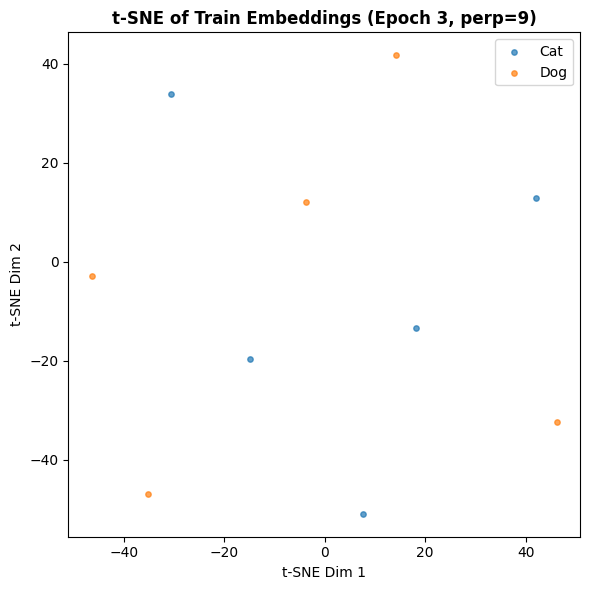

Epoch  3/5 | Train SupCon Loss=0.062 | Val Centroid Acc=0.755
  Batch 0: size=8, labels=[0, 1, 0, 0, 0, 1, 1, 1]
  Batch 1: size=2, labels=[1, 0]
  Processed 2/2 batches successfully


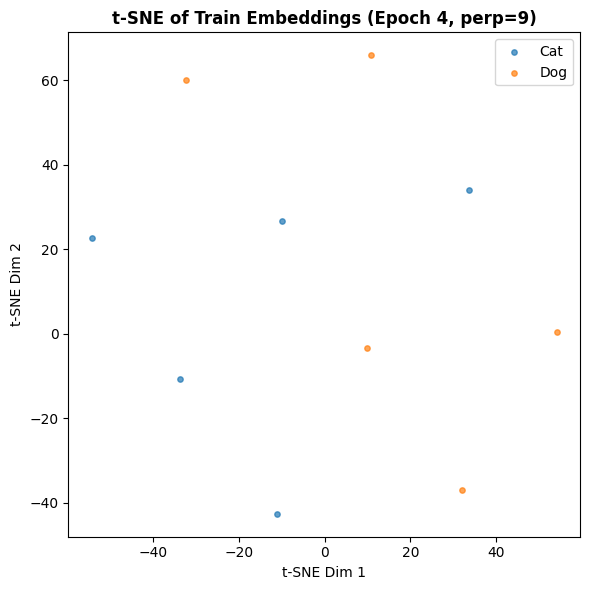

Epoch  4/5 | Train SupCon Loss=0.097 | Val Centroid Acc=0.755
  Batch 0: size=8, labels=[0, 1, 1, 1, 1, 0, 1, 0]
  Batch 1: size=2, labels=[0, 0]
  Skipping batch 1: size=2, unique_labels=1
  Processed 1/1 batches successfully


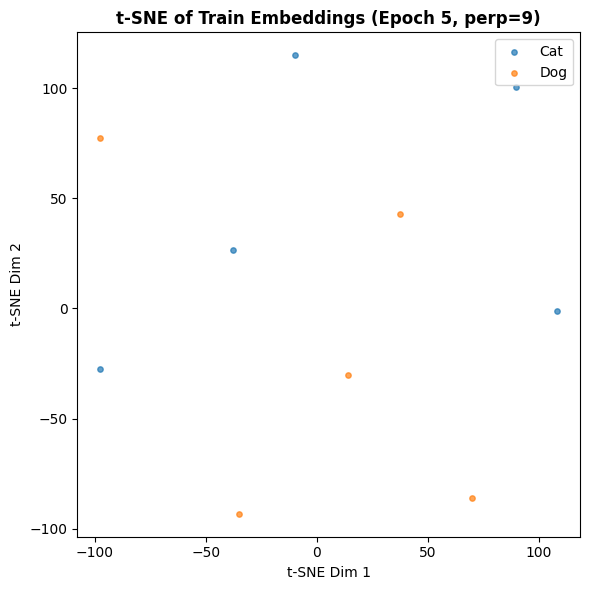

Epoch  5/5 | Train SupCon Loss=0.223 | Val Centroid Acc=0.755

Final Results (Supervised Contrastive):
Best Val Acc: 0.755 (epoch 3)
Test Centroid Acc: 0.743
Test Confusion Matrix:
  Cat predicted as: Cat=90, Dog=43
  Dog predicted as: Cat=0, Dog=34


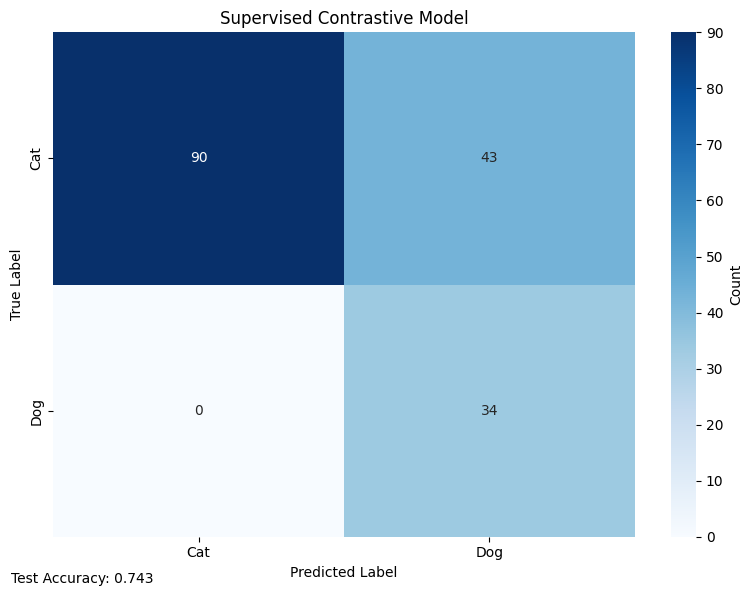

In [6]:
print('\n ****************************** supervised contrastive with over sampling Dog ****************************** \n')
model, results = train_supervised_contrastive_model(CONFIG)


 ****************************** triplet-based contrastive with over sampling Dog ****************************** 

Using device: cuda
Found 554 audio files: 441 cats, 113 dogs
Original distribution: 441 cats, 113 dogs
Added 226 replicated dog samples
New distribution: 441 cats, 339 dogs


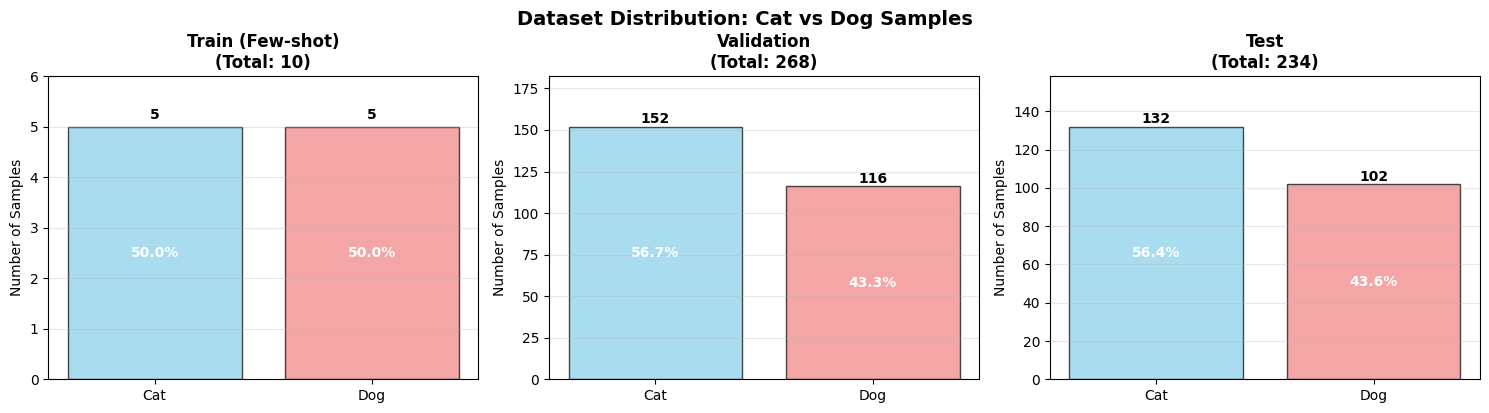


Dataset Distribution Summary:
----------------------------------------
Train (Few-shot): Cat= 5, Dog= 5, Total=10
Validation     : Cat=152, Dog=116, Total=268
Test           : Cat=132, Dog=102, Total=234
Dataset sizes: {'train': 10, 'val': 268, 'test': 234}
Training triplet contrastive model for 5 epochs...
Epoch  1/5 | Train: Loss=0.195, Triplet Acc=0.900 | Val Centroid Acc=0.828
Epoch  2/5 | Train: Loss=0.143, Triplet Acc=0.900 | Val Centroid Acc=0.832
Epoch  3/5 | Train: Loss=0.219, Triplet Acc=0.700 | Val Centroid Acc=0.817
Epoch  4/5 | Train: Loss=0.199, Triplet Acc=0.800 | Val Centroid Acc=0.821
Epoch  5/5 | Train: Loss=0.227, Triplet Acc=0.800 | Val Centroid Acc=0.821

Final Results (Triplet Contrastive):
Best Val Acc: 0.832 (epoch 2)
Test Centroid Acc: 0.812
Test Confusion Matrix:
  Cat predicted as: Cat=97, Dog=35
  Dog predicted as: Cat=9, Dog=93


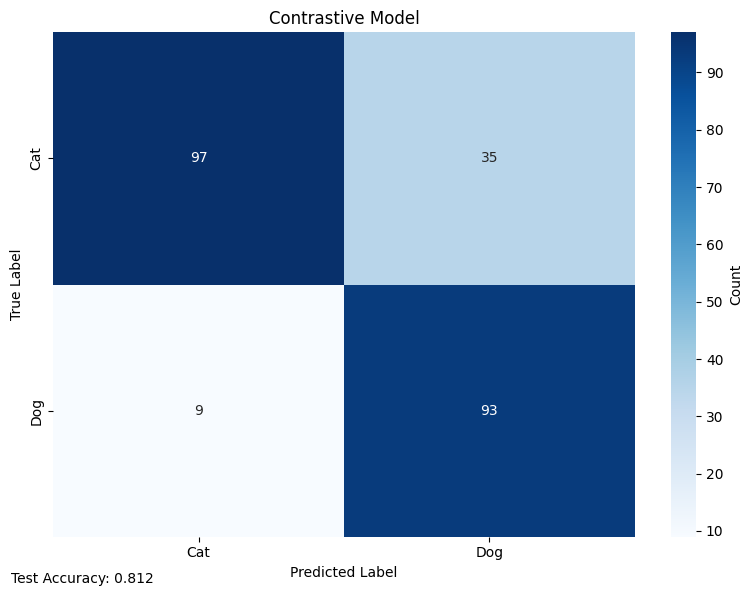

In [7]:
# Train using triplet-based contrastive loss
print('\n ****************************** triplet-based contrastive with over sampling Dog ****************************** \n')
model, results = train_contrastive_model(CONFIG)


### Discussion


`contrastive learning combined with oversampling` clearly outperformed the others with test accuracy of `0.81`.

Future Step can explore `data augmentation`, `lora fine tuning + contrastive leraning`, etc.